<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/gan_mlp_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pastrop/GANS.git@dcgan#egg=GANS

  Cloning https://github.com/pastrop/GANS.git (to revision dcgan) to /tmp/pip-install-oo29z_v1/GANS
  Running command git clone -q https://github.com/pastrop/GANS.git /tmp/pip-install-oo29z_v1/GANS
  Running command git checkout -b dcgan --track origin/dcgan
  Switched to a new branch 'dcgan'
  Branch 'dcgan' set up to track remote branch 'dcgan' from 'origin'.
  Created wheel for GANS: filename=GANS-0.1-cp37-none-any.whl size=9048 sha256=e9a1915eb8fd35d3034b6834a60415ce17c101bf519c97ebf3b922d6f97b8b51
  Stored in directory: /tmp/pip-ephem-wheel-cache-wfhns4vh/wheels/1b/ce/04/007373ba417e5310ae49447162c7c19156f5010908a96edecc
Successfully built GANS


In [2]:
#Standard Imports
import torch
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

#Custom Imports
from GANS import model

In [3]:
#Create a network
my_gan = model.GAN_MLP()
print(type(my_gan))

n_epochs = 1 #200
display_step = 100
lr = 0.00001

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
batch_size = 128

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cpu' # Use 'cuda' for any production run, 'cpu' is for testing ony

<class 'GANS.model.GAN_MLP'>


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...





/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Epoch 0, step 100: Generator loss: 0.7741752022504808, discriminator loss: 0.652700441479683


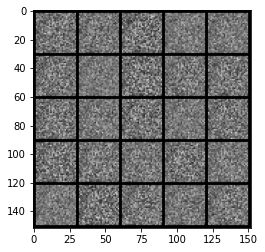

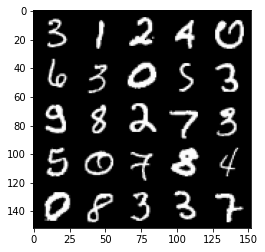

Epoch 0, step 200: Generator loss: 1.0706753128767013, discriminator loss: 0.49944179773330705


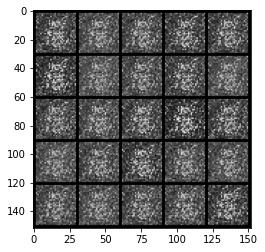

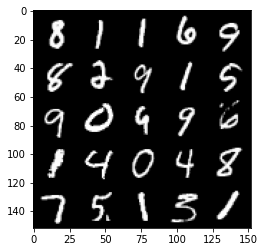

Epoch 0, step 300: Generator loss: 1.5069623517990112, discriminator loss: 0.3243925115466119


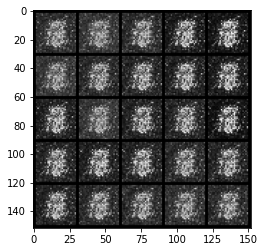

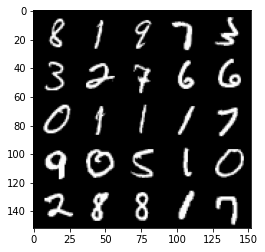

Epoch 0, step 400: Generator loss: 1.8476884663105013, discriminator loss: 0.2674121144413948


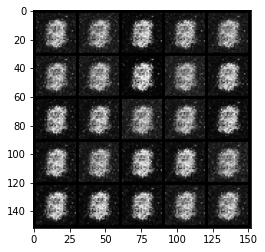

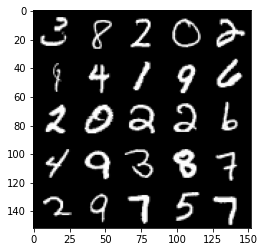

In [4]:
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zeroing the gradient
        my_gan.disc_opt.zero_grad()
        # Calculate discriminator loss
        disc_loss = my_gan.get_disc_loss(cur_batch_size, real)
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        my_gan.disc_opt.step()

        ### Update generator ###
        # Zeroing the gradient
        my_gan.gen_opt.zero_grad()
        # Calculate generator loss
        gen_loss = my_gan.get_gen_loss(cur_batch_size)
        # Update gradients
        gen_loss.backward(retain_graph=True)
        # Update optimizer
        my_gan.gen_opt.step()
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        #print(f'mean_discriminator_loss - {mean_discriminator_loss}; mean_generator_loss - {mean_generator_loss}')

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = my_gan.get_noise(cur_batch_size)
            fake = my_gan.gen(fake_noise)
            my_gan.show_tensor_images(fake)
            my_gan.show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

# Saving Model in Pytorch

In [12]:
my_gan.gen.state_dict().keys()
#my_gan.disc

odict_keys(['gen.0.0.weight', 'gen.0.0.bias', 'gen.0.1.weight', 'gen.0.1.bias', 'gen.0.1.running_mean', 'gen.0.1.running_var', 'gen.0.1.num_batches_tracked', 'gen.1.0.weight', 'gen.1.0.bias', 'gen.1.1.weight', 'gen.1.1.bias', 'gen.1.1.running_mean', 'gen.1.1.running_var', 'gen.1.1.num_batches_tracked', 'gen.2.0.weight', 'gen.2.0.bias', 'gen.2.1.weight', 'gen.2.1.bias', 'gen.2.1.running_mean', 'gen.2.1.running_var', 'gen.2.1.num_batches_tracked', 'gen.3.0.weight', 'gen.3.0.bias', 'gen.3.1.weight', 'gen.3.1.bias', 'gen.3.1.running_mean', 'gen.3.1.running_var', 'gen.3.1.num_batches_tracked', 'gen.4.weight', 'gen.4.bias'])

In [8]:
checkpoint = {'model': my_gan.gen,
              'state_dict': my_gan.gen.state_dict(),
              'optimizer' : my_gan.gen_opt.state_dict()}

torch.save(checkpoint, 'checkpoint_gen.pth')

In [10]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [13]:
trained_gen = load_checkpoint('checkpoint_gen.pth')